In [1]:
import pandas as pd

In [7]:
import numpy as np

In [78]:
from datetime import timedelta

In [2]:
technicals=pd.read_hdf('technicals.h5')

In [ ]:
#state is a 3*2*4*4+value dimensional matrix.

In [6]:
print(max(technicals.MACD),min(technicals.MACD))

(117.18402326246827, -143.82318300444433)


In [ ]:
np.logical_or(1.5)

In [66]:
#code in cell eases matrix indexing
def returnRSI(RSI):
    if 0<=RSI<20:
        return 0
    elif 20<=RSI<40:
        return 1
    elif 40<=RSI<60:
        return 2
    elif 60<=RSI<80:
        return 3
    else:
        return 4
#accepted range for MACD is -150 to 150
def returnMACD(MACD):
    if MACD<-90:
        return 0
    elif -90<MACD<-30:
        return 1
    elif -30<MACD<30:
        return 2
    elif 30<MACD<90:
        return 3
    else:
        return 4
#return traders cumulative profits in terms of positive and negative
def returnProfit(Profit):
    if Profit>=0:
        return 1
    else:
        return 0
#return current position in terms of long, short or flat
def returnPosition(Position):
    if Position>0:
        return 1
    elif Position==0:
        return 0
    else:
        return -1

In [33]:
#data partition
length=int(0.8*len(technicals))
temp=technicals.reset_index()
test=temp[temp.index<=length].set_index(['index'])
train=temp[temp.index>length].set_index(['index'])

In [87]:
nanless=test.dropna()
start_RSI=returnRSI(nanless.RSI[0])
start_MACD=returnMACD(nanless.MACD[0])

In [40]:
start_date=nanless.head().index[0]
end_date=nanless.tail(1).index[0]

In [90]:
#our nanless frame will basically become a sparsified verion of the technicals frame
nanless['StateRSI']=nanless['RSI'].apply(lambda x: returnRSI(x))
nanless['StateMACD']=nanless['MACD'].apply(lambda x: returnMACD(x))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [70]:
#define amount of buy or sell
lot_size=1

In [60]:
#define Q table, each value of Q has a different possible actions
#Q[s]=[long_val,hold_val,short_val]
#Q=3x2x5x5x3
#

In [72]:
class PnL:
    def __init__(self):
        #tracks current amount of symbol
        self.quantity = 0
        #cumulative sum of positions (net position)
        self.running_quantity=0
        #total negative from buying positions
        self.cost = 0.0
        #current market value of positions
        self.market_value = 0.0
        #realized pnl
        self.r_pnl = 0.0
        #average fill price of all positions
        self.average_price = 0.0
        #realized plus unrealized pnl is total pnl (ie what we want)
        self.total_pnl=0.0
    #function that processes fill statements
    def fill(self, n_pos, exec_price):
        #position delta from new buys
        pos_change = n_pos - self.quantity
        #buy or sell
        direction = sign(pos_change)
        #previous positioning
        prev_direction = sign(self.quantity)
        #quantity we end up with
        qty_closing = min(abs(self.quantity), abs(pos_change)) * direction if prev_direction != direction else 0
        #quantity we started with
        qty_opening = pos_change if prev_direction == direction else pos_change - qty_closing
        
        #updated cost with new positions
        new_cost = self.cost + qty_opening * exec_price
        #if the old position wasnt zero, modify cost for new amount *avg price
        #same for realized pnl
        if self.quantity != 0:
            new_cost += qty_closing * self.cost / self.quantity
            self.r_pnl += qty_closing * (self.cost / self.quantity - exec_price)

        #update current positioning, total positioning, cost
        self.quantity = n_pos
        self.running_quantity=n_pos+self.running_quantity
        self.cost = new_cost

    #update for market price and publish total_pnl
    def update(self, price):
        if self.quantity != 0:
            self.average_price = self.cost / self.quantity
        else: 
            self.average_price = 0
        self.market_value = self.quantity * price
        upl=self.market_value - self.cost
        self.total_pnl=upl+self.r_pnl
        return self.total_pnl

In [91]:
nanless.columns

Index([u'close', u'RSI', u'MACD', u'StateRSI', u'StateMACD'], dtype='object')

In [80]:
kappa=1e-4
gamma=0.999
alpha=0.001
epsilon=0.1 #run without initially, then with

In [81]:
#sparsify nanless so it runs faster
nanless=nanless[['close','StateRSI','StateMACD']]
#multiple yearly runs until convergence
while delta<converge:
    #btc=PnL()
    pastpnl=0
    pnl=0
    state=[]
    position=[]
    observedRSIs=[]
    observedMACDs
    cumpos=0
    #Run=pd.DataFrame(index=technicals.index,columns=['state','pnl','position','price'])
    #Run=Run.apply(transition,axis=1)
    #^experimental code to run with apply instead of iterrrows
    #initialize initial state w/0 PnL and 0 positions, initial 
    for i, row in nanless.iterrows():
        current_price=row['close']
        #index into Q[s] with latest item of state list and find action with maximum reward
        #modify the positioning state vars. append incremental position to position[], and add 
        #it to cumulative position
        next_row=nanless[nanless.index==i+timedelta(seconds=1)]
        if position[-1]!=0:
            #if we are taking a new position, we need to assign rewards
            btc.fill(position,currentprice)
            new_price=next_row['close']
            pnl=btc.update(new_price)
            delta_v=pastpnl-pnl
            reward=delta_v-0.5*kappa*delta_v**2
            #modify Qtable using bellman equation
        pastpnl=pnl
        p=returnProfit(pnl)
        discrete_position=returnPosition(position[-1])
        
        #append new state position to state[]
    #compute delta

NameError: name 'delta' is not defined

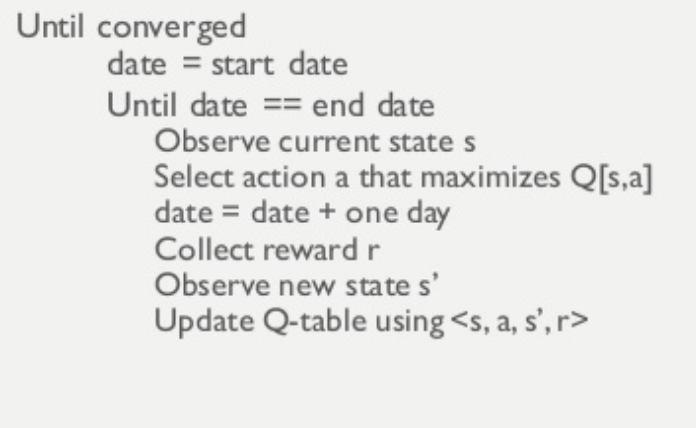

In [59]:
from IPython.display import Image
Image(filename='view.png') 

,close,RSI,MACD
2016-10-03 17:19:03,612.46,NaN,0.0


In [73]:
df = pd.DataFrame([[i] for i in range(10)], columns=['num'])

In [76]:
def powers(x):
    return x, x**2, x**3, x**4, x**5, x**6
df['p1'], df['p2'], df['p3'], df['p4'], df['p5'], df['p6'] =zip(*df.apply(lambda x: powers(x)))

ValueError: Length of values does not match length of index

In [75]:
df

,num,p1,p2,p3,p4,p5,p6
0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1
2,2,2,4,8,16,32,64
3,3,3,9,27,81,243,729
4,4,4,16,64,256,1024,4096
5,5,5,25,125,625,3125,15625
6,6,6,36,216,1296,7776,46656
7,7,7,49,343,2401,16807,117649
8,8,8,64,512,4096,32768,262144
9,9,9,81,729,6561,59049,531441
